# Is there a corelation between the weather or the days of the week and how much I tend to watch on Netflix?

Here we are going to analyze my Netflix viewing history from a downloaded csv file that lists the title of what I watched and the date of when I watched it. Combingin this with local weather data from an API and the days of the week will allow me to test if:

* I tend to watch more on the weekends
* Watch more when the weather is poor (ie. raining heavily)

To test this I will do a hypothesis test of the frequency of things watched on Saturdays and Sundays ( ie. my classification of the weekend) compared to how much I watched in the week (ie. Monday-Friday)


To do these test and combine these separate pieces of data. But, we first need to set up APIs to get the weather from certain days and the days of the week. 
Since the first instance from the NEtflix Viewing history csv file is dated "7/30/16" we need to import weather data and the days of the week from "7/30/16" to the last recorded day in the viewing hisotry file which is "4/9/2022".
>NOTE: for the weather I am going to just use the weather data from the Sammamish, WA area (where I live) since for the most part I watch netflix at home.

## Code to import all of the data
##### Importing the Weather
Getting the longitude and latitude for Sammamish.
This will allow me to use a spearate API to get the closest weather station ID to Sammamish

In [483]:
import json
import numpy as np
import pandas as pd
import requests

f = open("lat.txt", 'r')
key = f.read()
long_lat_url = "http://www.mapquestapi.com/geocoding/v1/address?key=" + key + "&location=Sammamish"
request_city = requests.get(long_lat_url)
json_city_str = request_city.text
json_city_obj = json.loads(json_city_str)

# getting latitiude and longititude of Sammamish
city_results_list = json_city_obj["results"]
dict = city_results_list[0]
locations_list = dict["locations"]
locations_dict = locations_list[0]
longLat_dict = locations_dict["displayLatLng"]
latitude = longLat_dict["lat"]
longitude = longLat_dict["lng"]

print("Sammamish latitude:", latitude)
print("Sammamish longitude:",longitude)

Sammamish latitude: 47.60553
Sammamish longitude: -122.035555


Getting the weather stations ID using a separate API:

In [484]:
f = open("Weather.txt", 'r')
key = f.read()
headers = {"x-rapidapi-key": key}
url = "https://meteostat.p.rapidapi.com/stations/nearby?lat=" + str(latitude) + "&lon=" + str(longitude) + "&limit=1"
request = requests.get(url = url, headers = headers)

json_station_str = request.text
json_station_obj = json.loads(json_station_str)
station_list = json_station_obj["data"]
station_dict = station_list[0]
station_id = station_dict["id"]
print("Weather Station ID:", station_id)

Weather Station ID: KRNT0


Now finally here we are loading the weather collected from this weather station from during the time period of 7/30/16 to 4/9/2022:

In [485]:
# get daily weather from station 2016-07-30 through 2022-04-09
headers = {"x-rapidapi-key": key}
weather_url = "https://meteostat.p.rapidapi.com/stations/daily?station="+ station_id + "&start=2016-07-30&end=2022-04-09"
request_weather = requests.get(url = weather_url, headers = headers)
json_weather_str = request_weather.text
json_weather_obj = json.loads(json_weather_str)
weather_df = pd.DataFrame(json_weather_obj["data"])
# weather_df.set_index("date", inplace = True)
weather_df.to_csv("daily_weather.csv")
print(weather_df)


            date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  \
0     2016-07-30  19.8  15.6  25.0   0.0  None    NaN  11.2  None  1014.1   
1     2016-07-31  18.4  14.4  22.8   0.0  None    NaN   9.1  None     NaN   
2     2016-08-01  18.0  12.8  25.0   0.0  None    NaN   6.9  None  1018.2   
3     2016-08-02  17.6  15.0  21.7   NaN  None    NaN   NaN  None     NaN   
4     2016-08-03  19.2  15.6  23.9   0.0  None    NaN   NaN  None  1024.2   
...          ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2075  2022-04-05   7.6   4.0  12.0   0.8  None  172.0  14.7  None  1025.3   
2076  2022-04-06   8.8   2.0  16.0   0.0  None    6.0   9.7  None  1030.7   
2077  2022-04-07  14.3   7.0  22.0   0.0  None  354.0   7.7  None  1021.4   
2078  2022-04-08  10.1   7.0  15.0  10.2  None  194.0  18.2  None  1022.6   
2079  2022-04-09   6.4   3.0   9.0   6.4  None  159.0  12.1  None  1024.6   

      tsun  
0     None  
1     None  
2     None  
3     None  
4     None

##### Importing the days of the week:
Next we need to load in the days of the week from 2016-07-30 through to 2022-04-09.
To do this we are using the datetime library to create a dataframe with the dates within this parameter and then the corresponding day of the week


In [486]:

date_df = pd.DataFrame()
date_df["Date"] = pd.Series(pd.date_range('2016-7-30', '2022-4-9', freq='D'))
date_df["Day of Week"] = date_df['Date'].dt.day_name()
# change to string so I can compare easily

change_ser = pd.Series(list(string))

for value in range(len(date_df["Date"])):
    temp = str(date_df["Date"][value]).split(" ")
    string = temp[0]
    change_ser[value] = string
date_df["Date"] = change_ser

print(type(date_df["Date"][1]))
date_df.set_index("Date", inplace = True)
date_df.to_csv("Days_of_The_Week.csv")
print(date_df)

<class 'str'>
           Day of Week
Date                  
2016-07-30    Saturday
2016-07-31      Sunday
2016-08-01      Monday
2016-08-02     Tuesday
2016-08-03   Wednesday
...                ...
2022-04-05     Tuesday
2022-04-06   Wednesday
2022-04-07    Thursday
2022-04-08      Friday
2022-04-09    Saturday

[2080 rows x 1 columns]


## Cleaning the data
Now that we have loaded all of the data we need to clean the files in order to accurately compute data and make hypotheses

#### Cleaning the Weather DataFrame
First we are going to clean the weather dataframe.
Converting the temperatures to farenheit and then deleting the columns with more than 50 percent of teh values missing

In [487]:
import utils
# Cleaning and Interpolating
weather_df.replace("", np.NaN, inplace = True)
length_df = len(weather_df)
for value in weather_df:
    ser = weather_df[value].copy()
    for i in range(len(ser)):
        # if col is something you can interpolate
        if(value == "tavg", "tmin", "tmax", "prcp", "wdir", "wspd", "pres" and ser.isnull()):
            ser.interpolate(inplace = True)
    weather_df[value] = ser
    # removing columns with more than 50 percent of values missing
    count = weather_df[value].isnull().sum()
    if count > (length_df / 2):
        del weather_df[value]

# converting to imperial
avg_temp_ser = weather_df["tavg"].copy()
min_temp_ser = weather_df["tmin"].copy()
max_temp_ser = weather_df["tmax"].copy()
for value in range(len(weather_df)):
    avg_temp_ser[value] = utils.convert_temp(avg_temp_ser[value])
    min_temp_ser[value] = utils.convert_temp(min_temp_ser[value])
    max_temp_ser[value] = utils.convert_temp(max_temp_ser[value])
weather_df["tavg"] = avg_temp_ser
weather_df["tmin"] = min_temp_ser
weather_df["tmax"] = max_temp_ser
weather_df = weather_df.rename({"date": "Date"}, axis = "columns")

weather_df.set_index("Date", inplace=True)
print(weather_df)

print(type(weather_df.index[0]))
weather_df.to_csv("cleaned_daily_weather.csv")


             tavg   tmin   tmax  prcp   wdir       wspd     pres
Date                                                            
2016-07-30  67.64  60.08  77.00   0.0    NaN  11.200000  1014.10
2016-07-31  65.12  57.92  73.04   0.0    NaN   9.100000  1016.15
2016-08-01  64.40  55.04  77.00   0.0    NaN   6.900000  1018.20
2016-08-02  63.68  59.00  71.06   0.0    NaN   8.566667  1021.20
2016-08-03  66.56  60.08  75.02   0.0    NaN  10.233333  1024.20
...           ...    ...    ...   ...    ...        ...      ...
2022-04-05  45.68  39.20  53.60   0.8  172.0  14.700000  1025.30
2022-04-06  47.84  35.60  60.80   0.0    6.0   9.700000  1030.70
2022-04-07  57.74  44.60  71.60   0.0  354.0   7.700000  1021.40
2022-04-08  50.18  44.60  59.00  10.2  194.0  18.200000  1022.60
2022-04-09  43.52  37.40  48.20   6.4  159.0  12.100000  1024.60

[2080 rows x 7 columns]
<class 'str'>


#### Cleaning the Date Column of the Netflix Dataframe
This will be converting the dates in this colunn from the format `4/9/22` to `2022-04-09`.
This will allow us the combine the other two data sets easily.

In [488]:
netflix_df = pd.read_csv("NetflixViewingHistory_project.csv")

date_ser = netflix_df["Date"].copy()

for date in range(len(date_ser)):
    temp = date_ser[date].split("/")
    year = "20" + temp[2]
    month = temp[0]
    if(len(temp[0]) == 1):
        month = "0" + month
    day = temp[1]
    if(len(temp[1]) == 1):
        day = "0" + day
    final = year + "-" + month + "-" + day
    date_ser[date] = final.strip()
netflix_df["Date"] = date_ser
netflix_df.to_csv("cleaned_Netflix_Viewing_History.csv")
print(netflix_df["Date"])

0       2022-04-09
1       2022-04-09
2       2022-04-08
3       2022-04-08
4       2022-04-05
           ...    
2468    2016-08-01
2469    2016-08-01
2470    2016-07-30
2471    2016-07-30
2472    2016-07-30
Name: Date, Length: 2473, dtype: object


#### Joining The Days Of The Week And The Weather For That Day:
We are doing this since each of these dataframes have keys of the date, which can only have one instance, and since it will make it easier to compare and visualize this data.

In [489]:
merged_weather_dayWeek_df = weather_df.merge(date_df, on = ["Date"], how= "inner")
print(merged_weather_dayWeek_df)

             tavg   tmin   tmax  prcp   wdir       wspd     pres Day of Week
Date                                                                        
2016-07-30  67.64  60.08  77.00   0.0    NaN  11.200000  1014.10    Saturday
2016-07-31  65.12  57.92  73.04   0.0    NaN   9.100000  1016.15      Sunday
2016-08-01  64.40  55.04  77.00   0.0    NaN   6.900000  1018.20      Monday
2016-08-02  63.68  59.00  71.06   0.0    NaN   8.566667  1021.20     Tuesday
2016-08-03  66.56  60.08  75.02   0.0    NaN  10.233333  1024.20   Wednesday
...           ...    ...    ...   ...    ...        ...      ...         ...
2022-04-05  45.68  39.20  53.60   0.8  172.0  14.700000  1025.30     Tuesday
2022-04-06  47.84  35.60  60.80   0.0    6.0   9.700000  1030.70   Wednesday
2022-04-07  57.74  44.60  71.60   0.0  354.0   7.700000  1021.40    Thursday
2022-04-08  50.18  44.60  59.00  10.2  194.0  18.200000  1022.60      Friday
2022-04-09  43.52  37.40  48.20   6.4  159.0  12.100000  1024.60    Saturday

#### Counting the number of things watched per day
After counting the amount of things watched for each day we can then merge it with the previously merged data to see all the data combined to one dataframe. This will also make analyzing this data much easier

In [490]:
watched_dates_list = list()
freq_list = list()
used_dates_list = list()
watched_dates_df = pd.DataFrame(columns = ["Date", "Things Watched"])
for date in netflix_df["Date"]:
    if date not in used_dates_list:
        used_dates_list.append(date)
        temp_df = netflix_df.loc[netflix_df["Date"] == date]
        watched_dates_list.append(date)
        freq_list.append(len(temp_df))
freq_list.reverse()
watched_dates_list.reverse()
watched_dates_df["Date"] = watched_dates_list
watched_dates_df["Things Watched"] = freq_list
watched_dates_df["Things Watched"] = watched_dates_df["Things Watched"].replace(" ", 0)
watched_dates_df.set_index("Date", inplace = True)
watched_dates_df.to_csv("Netflix_Frequency.csv")

fully_merged_df = merged_weather_dayWeek_df.merge(watched_dates_df, on = ["Date"], how= "outer")
print(fully_merged_df)
fully_merged_df.to_csv("Combined_Data.csv")


             tavg   tmin   tmax  prcp   wdir       wspd     pres Day of Week  \
Date                                                                           
2016-07-30  67.64  60.08  77.00   0.0    NaN  11.200000  1014.10    Saturday   
2016-07-31  65.12  57.92  73.04   0.0    NaN   9.100000  1016.15      Sunday   
2016-08-01  64.40  55.04  77.00   0.0    NaN   6.900000  1018.20      Monday   
2016-08-02  63.68  59.00  71.06   0.0    NaN   8.566667  1021.20     Tuesday   
2016-08-03  66.56  60.08  75.02   0.0    NaN  10.233333  1024.20   Wednesday   
...           ...    ...    ...   ...    ...        ...      ...         ...   
2022-04-05  45.68  39.20  53.60   0.8  172.0  14.700000  1025.30     Tuesday   
2022-04-06  47.84  35.60  60.80   0.0    6.0   9.700000  1030.70   Wednesday   
2022-04-07  57.74  44.60  71.60   0.0  354.0   7.700000  1021.40    Thursday   
2022-04-08  50.18  44.60  59.00  10.2  194.0  18.200000  1022.60      Friday   
2022-04-09  43.52  37.40  48.20   6.4  1

## Classifying whether the weather for a certain day was bad, decent, or good
Now we need an algorithm to signify whether or not the weather for a day was good bad or decent. This will allow me to distinguish if I tended to watch more when the weather was bad compared to when the weather was good. This will have to be decently arbritrary since it is really a matter of opinion if the weather is good or not for a certain day, so I will apply my own preferences to the weather since this is data collected on myself making it more or less accurate to my feelings or tendency to stay inside or be outside. Thus allowing us to see whether or not there is a correlation between these two attributes.

### Deciding what is good, bad, or decent weather
For me personally, coming from Washington, I would probably classify anything above the temperature of 65 degrees with no rain pretty good weather. At least to the point I would like to be outside instead of rotting away as I tend to do watching Netflix. So, based on this opinion of mine I would probably classify any day above the temperature 65 without rain a "good" weather day while anything from around 50 to 65 without rain a "decent" weather day and anything below 50, especially with rain, to be a bad weather day. Now the issue here is the rain. I woul probably call anything below the temperature of 70 with rain to be a "bad" weather day. Meaning I would probably rather be inside than outside if the weather was like that. So this leaves us with these classifications of weather:
* Good Weather
    * `fully_merged_df[Date][tavg] > 65 && prcp < 1`
* Decent Weather 
    * `fully_merged_df[Date][tavg] <= 65 && fully_merged_df[Date][tavg] > 50 && prcp < 1`
* Bad Weather 
    * `fully_merged_df[Date][tavg] <=50 && prcp < 1`
    * `fully_merged_df[Date][tavg] < 70 && prcp > 1`
### Utilizing Algorithm to Develop new Column

In [491]:
wthr_desc_df = pd.DataFrame(columns = ["Date", "tavg", "prcp", "Wthr Desc."])
wthr_desc_df["Date"] = fully_merged_df.index.tolist()
wthr_desc_df.set_index("Date", inplace=True)
tavg_ser = fully_merged_df["tavg"].copy()
wthr_desc_df["tavg"] = tavg_ser
wthr_desc_df["prcp"] = fully_merged_df["prcp"]
wthr_desc_ser = pd.Series(string)
for date in range(len(wthr_desc_df)):
    if wthr_desc_df["tavg"][date] > 65 and wthr_desc_df["prcp"][date] < 1:
        wthr_desc_ser[date] = "good"
    elif wthr_desc_df["tavg"][date] <= 65 and wthr_desc_df["tavg"][date] > 50 and wthr_desc_df["prcp"][date] < 1:
        wthr_desc_ser[date] = "decent"
    elif wthr_desc_df["tavg"][date] <= 50 and wthr_desc_df["prcp"][date] < 1:
        wthr_desc_ser[date] = "bad"
    elif wthr_desc_df["tavg"][date] <= 70 and wthr_desc_df["prcp"][date] >= 1:
        wthr_desc_ser[date] = "bad"
    else:
        wthr_desc_ser[date] = "decent"


wthr_desc_ser.index = fully_merged_df.index

fully_merged_df.insert(9, "Wthr Desc.", wthr_desc_ser)

fully_merged_df.to_csv("Combined_Data.csv")



## Visualizing the frequency of things watched per day
This will allow me to see if I tended to watch more on certain days. 

Text(0.5, 1.0, 'Days of the Week vs. Number of Things Watched')

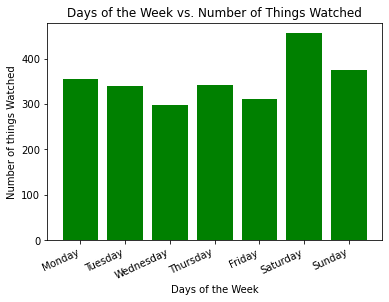

In [492]:
import matplotlib.pyplot as plt
days_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_freq = [0] * 7
for day in range(len(days_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == days_list[day]]
    frequency = temp_df["Things Watched"].sum()
    days_freq[day] = frequency

plt.figure()
plt.bar(days_list, days_freq, color = "green")
plt.xticks(rotation = 25, ha = "right")
plt.xlabel("Days of the Week")
plt.ylabel("Number of things Watched")
plt.title("Days of the Week vs. Number of Things Watched")

Here we can see that the diributio is decently normal. However the weekend does seem to be slightly larger. Lets graph the weekend (Saturday, Sunday) compared to weekdays (Monday, Tuesday, Wednesday, Thursday, Friday). ALthough we can also see that Saturday seems to have an unusually large frequency of things watched causing me to want to develop a hypothesis test to see if the frequency for Saturdays is significantly larger than, the rest of the week.

Weekday = 1643.0
Weekend = 830.0


Text(0.5, 1.0, 'Weekend or Weekday vs. Number of Things Watched')

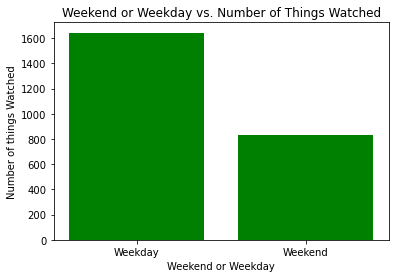

In [493]:
weekend_list = ["Saturday", "Sunday"]
weekend_freq = 0
weekday_freq = 0
weekday_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
frequency = 0
for day in range(len(weekend_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekend_list[day]]
    frequency = temp_df["Things Watched"].sum()
    weekend_freq += frequency
frequency = 0
for day in range(len(weekday_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekday_list[day]]
    frequency = temp_df["Things Watched"].sum()
    weekday_freq += frequency
print("Weekday =", weekday_freq)
print("Weekend =", weekend_freq)

plt.figure()
plt.bar(["Weekday", "Weekend"], [weekday_freq, weekend_freq], color = "green")
plt.xlabel("Weekend or Weekday")
plt.ylabel("Number of things Watched")
plt.title("Weekend or Weekday vs. Number of Things Watched")


Here we can see that the Weekdays have a slightly higher frequency of things watched. However, this is the combonation of 4 different days in the week compared to my classification of the weekend with only 3 days. Hinting to the fact that the weekend despite having less days might have had a higher frequency on average. 

## Visualizing Things Watched per day based on Weather Descriptions
This will allow us to see if there is a corelation between the weather for the day and the number of things watched.

Text(0.5, 1.0, 'Description of the Weather vs. # of Things Watched')

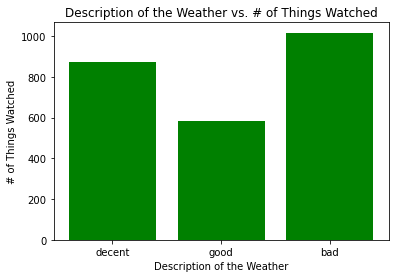

In [494]:
descr_list = ["decent", "good", "bad"]
freq_list = [0] * 3
for descr in range(len(descr_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Wthr Desc."] == descr_list[descr]]
    frequency = temp_df["Things Watched"].sum()
    freq_list[descr] = frequency
plt.figure()
plt.bar(descr_list, freq_list, color = "green")
plt.xlabel("Description of the Weather")
plt.ylabel("# of Things Watched")
plt.title("Description of the Weather vs. # of Things Watched")

While bad weather isnt signficantly higher than both decent or good weather days we can still test wheather or not Bad is significantly higher than things watched on a good weather day

## Hypothesis Testing 
Based on the two previous visualizations I believe two different hypothesis test we could conduct would be to see if the average number of things watched for the weekend day is significantly higher than that of a weekday. Then another test we could conduct could be to see if the avergae number of things watched on a day classified with good weather is significantly lower than that of a day with decent or good weather.

### Is the number of things watched on average for the day of the Saturday higher than that of a Weekday?
Using a significance level of .025 we are going to compute a two independent sample one tailed hypothesis test asking if the average number of things watched on a Saturday higher than that of a weekday?
##### Calculations
Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Week} >= \mu_{Saturday}$
* $H_{1} = \mu_{Week} < \mu_{Saturday}$

Level of Significance:
* $\alpha = .025$

Test Statistic:
* will be using a t-test:
$$t = \frac{\overline{X}_{Week} - \overline{X}_{Saturday}}{\sqrt{S_p^2(\frac{1}{n_{Week}})+(\frac{1}{n_{Saturday}})}}$$
$$S_p^2 = \frac{(n_{Week} - 1)s_{Week}^2 + (n_{Saturday} - 1)s_{Saturday}^2}{n_{Week} + n_{Saturday} - 2}$$

Degrees Freedom:
* $df = n_{March} + n_{September} - 2$

T-Critical:
* $t_{crit} = 1.960$

Decision Rule:
* If the value of t is larger than that of $t_{crit}$ then wewill have enough evidence to reject the null hypothesis. Meaning that the average number of things Watched is higher on a Saturday than the average number of things watched on a weekday .

In [495]:
from scipy import stats
weekday_sums_list = [0] * 5

for weekday in range(len(weekday_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekday_list[weekday]]
    weekday_sums_list[weekday] = temp_df["Things Watched"].mean()
weekday_ser = pd.Series(weekday_sums_list)
print(weekday_ser.mean())

saturday_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == "Saturday"]
saturday_ser = saturday_df["Things Watched"] 
print(saturday_ser.mean())

t, pval = stats.ttest_ind(saturday_ser, weekday_ser, equal_var=False, nan_policy="omit")
pval /= 2
alpha = .025

print("t =", t, "pval =", pval)

if pval < alpha:
    print("reject H0")
else:
    print("do not reject H0")

2.946966444565867
3.081081081081081
t = 0.5477797854206885 pval = 0.29253461371720574
do not reject H0


Here we can see that the means for things watched during the weekday and Saturday are very similar. To add on, this means that we cannot reject the null hypothesis that the mean of things watched during the week are greater than or equal to teh avergae nuber of things watched on a Saturday

### Is the number of things watched on average for the Weekend higher than that of a Weekday?
Using a significance level of .1 we are going to compute a two independent sample one tailed hypothesis test asking if the average number of things watched on the weekend higher than that of a weekday?
##### Calculations
Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Week} >= \mu_{Weekend}$
* $H_{1} = \mu_{Week} < \mu_{Weekend}$

Level of Significance:
* $\alpha = .1$

Test Statistic:
* will be using a t-test:
$$t = \frac{\overline{X}_{Week} - \overline{X}_{Weekend}}{\sqrt{S_p^2(\frac{1}{n_{Week}})+(\frac{1}{n_{Weekend}})}}$$
$$S_p^2 = \frac{(n_{Week} - 1)s_{Week}^2 + (n_{Weekend} - 1)s_{Weekend}^2}{n_{Week} + n_{Weekend} - 2}$$

Degrees Freedom:
* $df = n_{March} + n_{September} - 2$

T-Critical:
* $t_{crit} = 1.282$

Decision Rule:
* If the value of t is larger than that of $t_{crit}$ then we will have enough evidence to reject the null hypothesis. Meaning that the average number of things Watched is higher on the Weekend than the average number of things watched on a weekday .

In [496]:
weekend_sums_list = [0] * 2

for weekend in range(len(weekend_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekend_list[weekend]]
    weekend_sums_list[weekend] = temp_df["Things Watched"].mean()
weekend_ser = pd.Series(weekend_sums_list)
print(weekend_ser.mean())




t, pval = stats.ttest_ind(weekend_ser, weekday_ser, equal_var=False, nan_policy="omit")
pval /= 2
alpha = .1

print("t =", t, "pval =", pval)

if pval < alpha:
    print("reject H0")
else:
    print("do not reject H0")

3.1666274970622794
t = 1.7460868807086138 pval = 0.08298895031778245
reject H0


Now since the calculated T is higher than T critical with a significance of .1 we have enough evidence to reject the null Hypothesis and accept that the average number of things watched on the Weekend is higher than that of the weekday